In [6]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  
sys.path.append(project_root)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scripts.resnet_model import get_resnet18

In [7]:
train_dir ="C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/driver_behavior/train/"
test_dir = "C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/driver_behavior/test/"
model_save_path = "C:/Users/Badis/Desktop/vehicle-monitoring-system/models/resnet18_driver_behavior.pth"

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Classes: {train_dataset.classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Classes: ['drinking', 'playing_radio', 'regular_conductor', 'seeing_behind', 'using_phone']
Number of training samples: 9118
Number of testing samples: 2277


In [12]:
model = get_resnet18(num_classes=len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
train_losses = []
test_losses = []
best_acc = 0.0

c:\Users\Badis\Desktop\vehicle-monitoring-system\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Badis\Desktop\vehicle-monitoring-system\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Badis/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:45<00:00, 1.02MB/s]


In [13]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
 
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))
    print(f"Training Loss: {train_losses[-1]:.4f}")
 
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions.extend(torch.argmax(outputs, 1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    test_losses.append(test_loss / len(test_loader))
    acc = accuracy_score(true_labels, predictions)
    print(f"Validation Loss: {test_losses[-1]:.4f}, Accuracy: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), model_save_path)
        print("Saved Best Model!")
print("\nEvaluating on Test Set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions.extend(torch.argmax(outputs, 1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=train_dataset.classes))


Epoch 1/10
Training Loss: 0.0965
Validation Loss: 0.0403, Accuracy: 0.9917
Saved Best Model!
Epoch 2/10
Training Loss: 0.0358
Validation Loss: 0.0213, Accuracy: 0.9965
Saved Best Model!
Epoch 3/10
Training Loss: 0.0288
Validation Loss: 0.1009, Accuracy: 0.9701
Epoch 4/10
Training Loss: 0.0227
Validation Loss: 0.0173, Accuracy: 0.9947
Epoch 5/10
Training Loss: 0.0106
Validation Loss: 0.0110, Accuracy: 0.9978
Saved Best Model!
Epoch 6/10
Training Loss: 0.0159
Validation Loss: 0.0299, Accuracy: 0.9908
Epoch 7/10
Training Loss: 0.0115
Validation Loss: 0.0432, Accuracy: 0.9877
Epoch 8/10
Training Loss: 0.0263
Validation Loss: 0.0085, Accuracy: 0.9991
Saved Best Model!
Epoch 9/10
Training Loss: 0.0062
Validation Loss: 0.2224, Accuracy: 0.9469
Epoch 10/10
Training Loss: 0.0038
Validation Loss: 0.0088, Accuracy: 0.9987

Evaluating on Test Set...


C:\Users\Badis\AppData\Local\Temp\ipykernel_27096\3514366157.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))



Classification Report:
                   precision    recall  f1-score   support

         drinking       1.00      1.00      1.00       465
    playing_radio       1.00      1.00      1.00       462
regular_conductor       1.00      1.00      1.00       497
    seeing_behind       1.00      1.00      1.00       400
      using_phone       1.00      1.00      1.00       453

         accuracy                           1.00      2277
        macro avg       1.00      1.00      1.00      2277
     weighted avg       1.00      1.00      1.00      2277



In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
all_preds_train = []
all_labels_train = []

In [18]:
with torch.no_grad():
    for inputs, labels in train_loader:  # `train_loader` is your DataLoader for the training set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Define class names based on dataset folders or predefined labels
class_names = ["drinking", "playing_radio", "regular_conductor", "seeing_behind", "using_phone"]

# Generate classification report for training set
print("Classification Report (Training Set):")
print(classification_report(all_labels_train, all_preds_train, target_names=class_names))


Classification Report (Training Set):
                   precision    recall  f1-score   support

         drinking       1.00      1.00      1.00      3720
    playing_radio       1.00      1.00      1.00      3700
regular_conductor       1.00      1.00      1.00      3984
    seeing_behind       1.00      1.00      1.00      3204
      using_phone       1.00      1.00      1.00      3628

         accuracy                           1.00     18236
        macro avg       1.00      1.00      1.00     18236
     weighted avg       1.00      1.00      1.00     18236



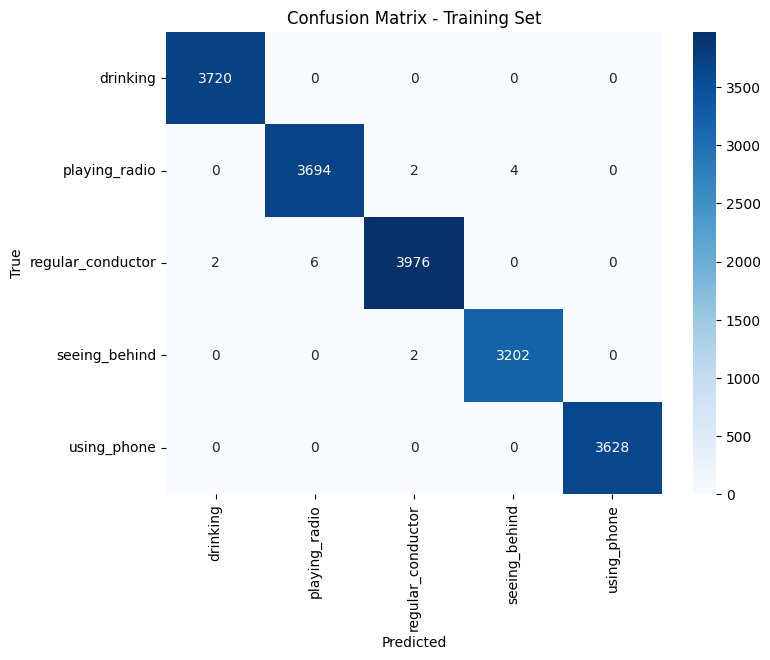

In [19]:
cm_train = confusion_matrix(all_labels_train, all_preds_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [20]:
import random
from torchvision.transforms.functional import to_pil_image

In [22]:
from collections import Counter

class_distribution = Counter()
for _, labels in test_loader:
    class_distribution.update(labels.tolist())

print("Class Distribution in Test DataLoader:")
for class_idx, count in class_distribution.items():
    print(f"{class_names[class_idx]}: {count} samples")


Class Distribution in Test DataLoader:
drinking: 465 samples
playing_radio: 462 samples
regular_conductor: 497 samples
seeing_behind: 400 samples
using_phone: 453 samples


In [23]:
print("Class Names:", class_names)


Class Names: ['drinking', 'playing_radio', 'regular_conductor', 'seeing_behind', 'using_phone']


In [25]:
def evaluate_model_on_test(model, test_loader, class_names):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report (Test Set):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

evaluate_model_on_test(model, test_loader, class_names)


Classification Report (Test Set):
                   precision    recall  f1-score   support

         drinking       1.00      1.00      1.00       465
    playing_radio       1.00      1.00      1.00       462
regular_conductor       1.00      1.00      1.00       497
    seeing_behind       1.00      1.00      1.00       400
      using_phone       1.00      1.00      1.00       453

         accuracy                           1.00      2277
        macro avg       1.00      1.00      1.00      2277
     weighted avg       1.00      1.00      1.00      2277

